In [13]:
from src.model import LinearLayer, ReLU, CrossEntropyLoss, Softmax
from src.optimizer import SGDWithMomentum
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


In [14]:
# Load the MNIST dataset
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
dataset = fetch_openml('mnist_784', as_frame=False, cache=True)

In [15]:
#prepare data
X = dataset.data.astype('float32')
y = dataset.target.astype('int64')
X /= 255.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [16]:
input_layer = LinearLayer(784, 256)
relu1 = ReLU()
hidden_layer = LinearLayer(256, 128)
relu2 = ReLU()
output_layer = LinearLayer(128, 10)
criterion = CrossEntropyLoss()

# Initialize optimizer
model = [input_layer, hidden_layer, output_layer]
optimizer = SGDWithMomentum(model, learning_rate=0.01, momentum=0.9)

# Early Stop Parameters
patience = 3
trigger_times = 0
best_loss = float('inf')

# Training loop
num_epochs = 60
batch_size = 32

for epoch in range(num_epochs):
    epoch_loss = 0
    correct = 0
    total = 0
    
    for i in range(0, len(X_train), batch_size):
        data = X_train[i:i+batch_size]
        target = y_train[i:i+batch_size]
        
        # Forward pass
        out = input_layer.forward(data)
        out = relu1.forward(out)
        out = hidden_layer.forward(out)
        out = relu2.forward(out)
        logits = output_layer.forward(out)
        loss = criterion.forward(logits, target)
        
        # Backward pass
        grad_loss = criterion.backward()
        grad_output = output_layer.backward(grad_loss)
        grad_relu2 = relu2.backward(grad_output)
        grad_hidden = hidden_layer.backward(grad_relu2)
        grad_relu1 = relu1.backward(grad_hidden)
        grad_input = input_layer.backward(grad_relu1)

        optimizer.step()
        optimizer.zero_grad()
        
        epoch_loss += loss
        
        # Calculate accuracy
        predicted = np.argmax(logits, axis=1)
        total += target.size
        correct += (predicted == target).sum()
    
    avg_loss = epoch_loss / (len(X_train) / batch_size)
    accuracy = 100 * correct / total
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping on epoch:', epoch)
            break

Epoch [1/60], Loss: 0.7417, Accuracy: 74.88%
Epoch [2/60], Loss: 0.1649, Accuracy: 95.11%
Epoch [3/60], Loss: 0.1026, Accuracy: 96.96%
Epoch [4/60], Loss: 0.0735, Accuracy: 97.86%
Epoch [5/60], Loss: 0.0541, Accuracy: 98.49%
Epoch [6/60], Loss: 0.0413, Accuracy: 98.85%
Epoch [7/60], Loss: 0.0310, Accuracy: 99.15%
Epoch [8/60], Loss: 0.0241, Accuracy: 99.35%
Epoch [9/60], Loss: 0.0175, Accuracy: 99.58%
Epoch [10/60], Loss: 0.0142, Accuracy: 99.64%
Epoch [11/60], Loss: 0.0106, Accuracy: 99.74%
Epoch [12/60], Loss: 0.0084, Accuracy: 99.82%
Epoch [13/60], Loss: 0.0064, Accuracy: 99.87%
Epoch [14/60], Loss: 0.0048, Accuracy: 99.91%
Epoch [15/60], Loss: 0.0034, Accuracy: 99.96%
Epoch [16/60], Loss: 0.0026, Accuracy: 99.97%
Epoch [17/60], Loss: 0.0018, Accuracy: 99.99%
Epoch [18/60], Loss: 0.0013, Accuracy: 99.99%
Epoch [19/60], Loss: 0.0009, Accuracy: 100.00%
Epoch [20/60], Loss: 0.0007, Accuracy: 100.00%
Epoch [21/60], Loss: 0.0006, Accuracy: 100.00%
Epoch [22/60], Loss: 0.0005, Accuracy: 1

Test Accuracy: 97.99%
Precision: 0.98
Recall: 0.98


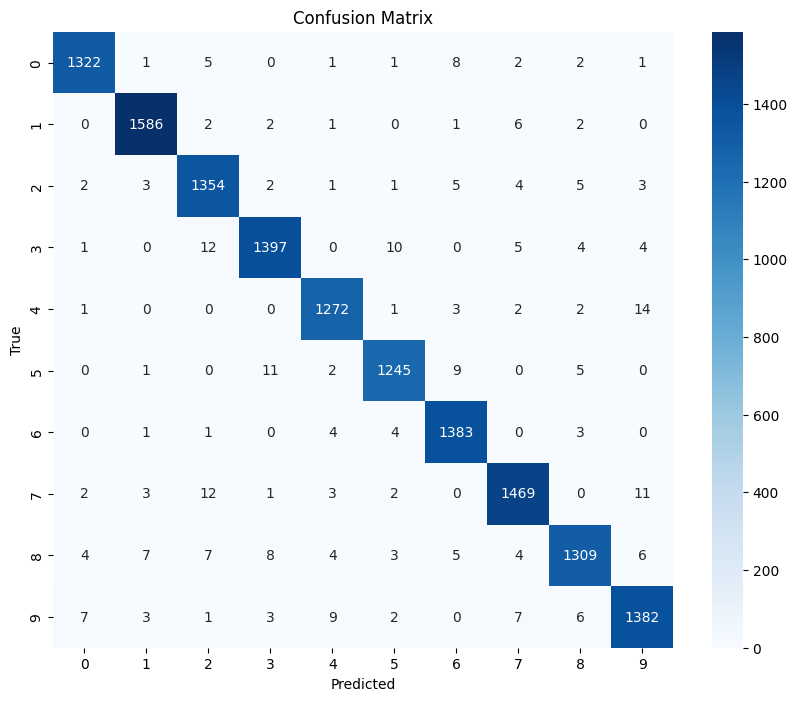

In [17]:
softmax = Softmax()
correct = 0
total = 0
all_targets = []
all_predictions = []

for data, target in zip(X_test, y_test):
    # Forward pass
    out = input_layer.forward(data)
    out = relu1.forward(out)
    out = hidden_layer.forward(out)
    out = relu2.forward(out)
    out = output_layer.forward(out)
    logits = softmax.forward(out)
    
    predicted = np.argmax(logits, axis=1)
    all_targets.append(target)
    all_predictions.append(predicted)
    total += target.size
    correct += (predicted == target).sum()

accuracy = 100 * correct / total
precision = precision_score(all_targets, all_predictions, average='macro')
recall = recall_score(all_targets, all_predictions, average='macro')
conf_matrix = confusion_matrix(all_targets, all_predictions)

print(f'Test Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

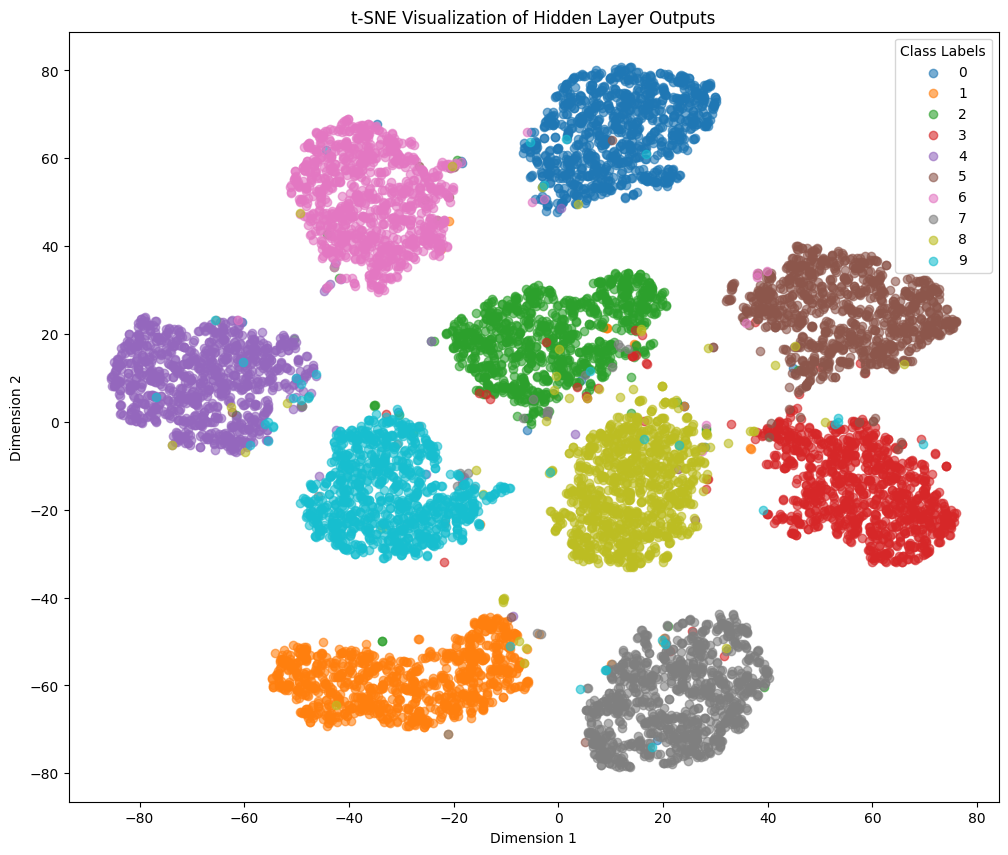

In [18]:
# Ensure reproducibility
np.random.seed(42)

# Step 1: Randomly select 1,000 samples from each class
indices = []
for class_label in range(10):
    class_indices = np.where(y_test == class_label)[0]
    selected_indices = np.random.choice(class_indices, 1000, replace=False)
    indices.extend(selected_indices)

indices = np.array(indices)
np.random.shuffle(indices)

# Extract the selected data and labels
selected_data = X_test[indices]
selected_labels = y_test[indices]

# Step 2: Pass the samples through the model up to the hidden layer
# Note: Adjust this part if your layers require different input shapes
out = input_layer.forward(selected_data)
out = relu1.forward(out)
out = hidden_layer.forward(out)
hidden_features = relu2.forward(out)  # Shape: (10000, 128)

# Step 3: Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(hidden_features)  # Shape: (10000, 2)

# Step 4: Plot the 2D features with class labels
plt.figure(figsize=(12, 10))

# Create a color map with 10 colors for the 10 classes
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i in range(10):
    idx = selected_labels == i
    plt.scatter(features_2d[idx, 0], features_2d[idx, 1], color=colors[i], label=str(i), alpha=0.6)

plt.legend(title='Class Labels')
plt.title('t-SNE Visualization of Hidden Layer Outputs')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Step 5: Save the plot
plt.savefig('feature_visualization.jpg')
plt.show()
